In [1]:
import yaml
import os 
import essentia
from essentia.standard import *
import IPython
import matplotlib.pyplot as plt
import numpy as np

with open('../master-dynamics/metadata/genres.yaml') as g:
    genres = yaml.load(g, Loader=yaml.FullLoader)
    
with open('../master-dynamics/metadata/ids.yaml') as i:
    ids = yaml.load(i, Loader=yaml.FullLoader)


[   INFO   ] MusicExtractorSVM: no classifier models were configured by default


## Analitzant la base de dades

### Primera presa de contacte
Aquí es pot observar la organització de la base de dades. Trobem un total de 18 generes musicals. Les cancons estan ennumerades de l'1 al 682. Tot i així al directori es conta un total de 488 fitxers, cada un amb el nom %d.mp3.


In [2]:
all_genres = set(genres.values())
print(all_genres)

{'k-pop', 'classical', 'disco', 'country', 'motown', 'electronic', 'jazz', 'reggaeton', 'pop', 'metal', 'rock', 'rhythm and blues', 'orchestral', 'funk', 'soul', 'house', 'reggae', 'hip-hop'}


In [3]:
count = 0
path = '../master-dynamics/audio/'
for root_dir, cur_dir, files in os.walk(path):
    count += len(files)
print('file count:', count)

file count: 488


### Escull la cançó

In [4]:
num_song = 258

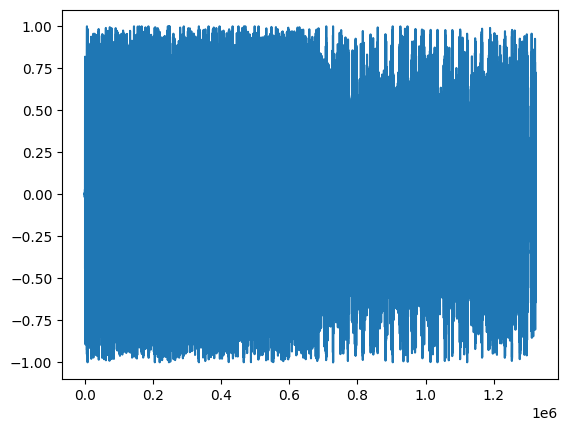

In [5]:
file_name = '{}{}.mp3'.format(path,num_song)
#check if exists
audio = MonoLoader(filename=file_name)()
stereo, fs, n_channels, md5, bit_rate, codec = AudioLoader(filename=file_name)() #dos arrays esquerra i dreta
plt.plot(audio)
plt.show()

In [6]:
IPython.display.Audio(file_name)

In [7]:
print('Musical genre: ',genres[num_song])

Musical genre:  metal


# Extractors

#### RMS
Aquest algoritme calcula la mitjana quadràtica. És útil per a obtenir una valoració sobre el soroll percebut per l'oïent. Utilitzar una eina de medició per RMS ajudarà a evitar distorció especialment per cançons fortes.
https://essentia.upf.edu/reference/std_RMS.html

In [8]:
def rms_(audio):
    rms = RMS()
    return rms(audio)

print('RMS: ', rms_(audio))

RMS:  0.33617156744003296


#### LRA i LUFS (decidir quins utilitzar)
LRA és el loudness range i quantifica la variació d'una mesura de loudness en el temps.
LUFS és el nivell d'unitats de soroll relatiu al nivell màxim que pot manejar un sistema.

L'algotitme EBU R128 dona una descripció del soroll del senyal d'audio.

The input stereo signal is preprocessed with a K-weighting filter [2] (see LoudnessEBUR128Filter algorithm), composed of two stages: a shelving filter and a high-pass filter (RLB-weighting curve).

· El sorolll momentani es calcula a partir d'integrar la suma de potències sobre una enfinastrament rectangular de 400 ms.

·El soroll the de curta durada 'short-term' es calcula a partir d'integrar la suma de potències amb un enfinastrament rectangular de 3 segons.

· El soroll integrat (integrated loudness) is un valor mitjà de soroll sobre un interval llarg de temps arbitrari amb un gating de blocks de 400 ms amb dos llindars: El gating del llindar de silenci absolut (-70 LUFS) i el gating del llindar relatiu, 10 LU per sota del absolute-gated loudness level.

·Loudness range es calcula a partir del soroll calculat dels valors de short-term loudness. És la diferència entre el 10è i 95è percentils estimats de la distribució del soroll amb el gating aplicat.Amb el llindar de l'absolute-gated loudness level a -70 LUFS i el llindar del relative gated -20 LU per sota.

https://essentia.upf.edu/reference/std_LoudnessEBUR128.html

In [9]:
def LUFS_LRA_(audio):
    
    ebur128 = LoudnessEBUR128()
    stereomuxer = StereoMuxer()
    if audio.ndim == 2:  
        audio = stereomuxer(audio[:,0], audio[:,1])
    else:
        audio = stereomuxer(audio, audio)
    
    ML, SL, IL, LRA = ebur128(stereo)
    return ML, SL, IL, LRA

print('Integrated loudness: ', LUFS_LRA_(stereo)[2], 'LUFS')
print('LRA: ', LUFS_LRA_(stereo)[3], 'LU')

Integrated loudness:  -6.7744598388671875 LUFS
LRA:  1.3586435317993164 LU


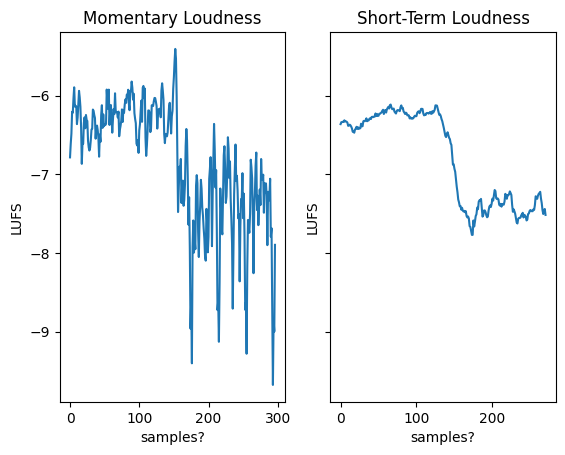

In [10]:
plt.show()
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(LUFS_LRA_(stereo)[0])
ax1.set_title('Momentary Loudness')
ax1.set_ylabel('LUFS')
ax1.set_xlabel('samples?')
ax2.plot(LUFS_LRA_(stereo)[1])
ax2.set_title('Short-Term Loudness')
ax2.set_ylabel('LUFS')
ax2.set_xlabel('samples?')
plt.show()


#### True Peak (part a revisar + implementar)
https://essentia.upf.edu/tutorial_audioproblems_truepeakdetector.html

Aquest algoritme encapsula la idea de inter-sample peaks, però resulta impossible calcular-los fins que no es converteixi el senyal a analògic. En el pitjor dels casos un inter-sample peak caurà fora del rang dinàmic generant un clipping que no pot ser percebut en digital.
https://essentia.upf.edu/reference/std_TruePeakDetector.html
Aquest algoritme implementa una mètrica true peak. Els valors d'aquests pics superen el rang  màxim i són potencials fonts de clipping en processos com els que fan els conversors de digital a analògic.


In [11]:
def true_peak_(audio):
    peak_locations, output = TruePeakDetector(version=2)(audio)
    return peak_locations, output

print(len(true_peak_(audio)[0]))



147


Aleshores el que tenim en primer lloc és un audio amb una certa amplitud entre -1 i 1 d'una durada de x samples, que podem escalar a dB i segons. 
La recomanació per a aquest algorisme (ITU-R BS.1770) es basa en una tècnica d'oversample. És a dir tenim el nostre senyal en dB tal i com podem veure a continuació.

/tmp/ipykernel_16468/370854352.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(time,20*np.log10(abs(audio)))


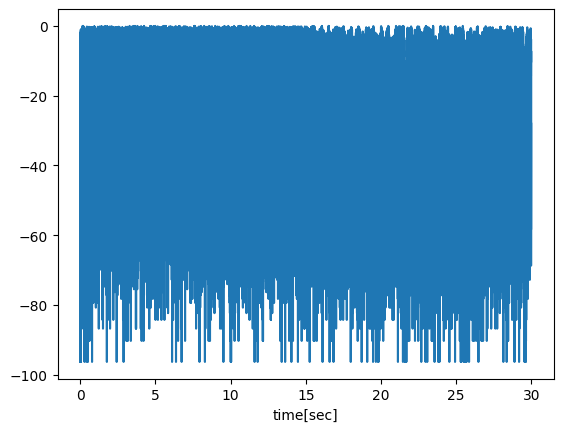

In [12]:
fs = 44100
time = np.linspace(0, len(audio) / fs, num = len(audio))
plt.plot(time,20*np.log10(abs(audio)))
plt.xlabel('time[sec]')
plt.show()

Aleshores el que s'ha de fer és  fer un oversample x4 i després fer uns abs() dels nous valors d'audio en dB.
S'utilitza un threshold de -0.0002 com a default.

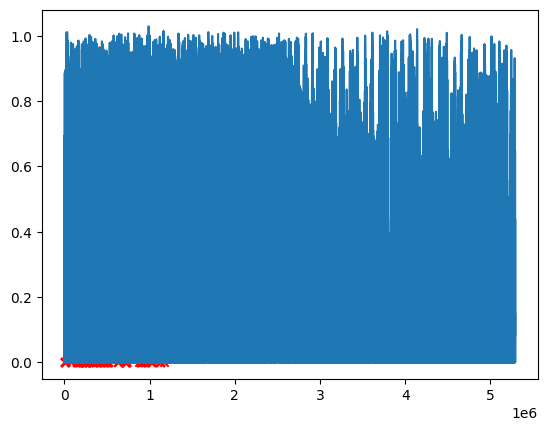

[   6763.    6763.    6763.    6763.    8560.    8560.    8560.    8560.
   73809.  144717.  144717.  144717.  144718.  160475.  160475.  160475.
  160476.  160485.  160486.  167338.  167338.  167338.  187034.  187034.
  187034.  205308.  205308.  205308.  205798.  205798.  207326.  207326.
  220064.  220064.  244088.  244088.  244089.  244089.  247283.  247393.
  247393.  247393.  247394.  249103.  249103.  249103.  249104.  249104.
  249943.  290769.  290769.  290769.  291116.  291116.  291116.  334805.
  335055.  335055.  335056.  335057.  335188.  335188.  335188.  335189.
  335189.  335190.  363444.  363445.  363445.  378741.  395754.  422573.
  422573.  451060.  451060.  451060.  466638.  466638.  466638.  466639.
  467492.  467492.  467492.  467492.  471444.  471445.  487815.  487816.
  498621.  498621.  498653.  498653.  498653.  498653.  510025.  510025.
  510025.  510025.  629878.  629878.  629878.  708680.  708680.  708681.
  728474.  728474.  728474.  728475.  728496.  7284

In [13]:
fs = 44100.
eps = np.finfo(np.float32).eps

times = np.linspace(0, len(audio) / fs, len(audio))

peakLocations, output = TruePeakDetector(version=2)(audio)


plt.plot(output)
plt.scatter(peakLocations, np.zeros(len(peakLocations)),marker='x',color='r')

plt.show()
print(peakLocations)

Per tant, ara podríem calcular el valor en dB dels peaks

#### Factor cresta
https://essentia.upf.edu/reference/std_Crest.html
El factor cresta es defineix com el ratio entre el valor maxim i la mitjana aritmètica.

In [14]:
def crest_(audio):
    crest = Crest()
    return crest(true_peak_(audio)[1])

print(crest_(audio))

3.863036870956421


#### Rang Dinàmic 
Es pot treure amb RMS i el peak, ja que el valor RMS és el valor nominal, de manera que la diferència entre aquest i el peak serà el rang dinàmic.

In [15]:
def DR_(audio):
    dB_audio = 20*np.log10(output)
    return max(dB_audio)-min(dB_audio) 
    

    
DR_(audio)

196.00533

#### LR-MS 

MS stands for Mid/Side, and is traditionally used as a recording technique with the aid of a MS microphone. M stands for Mid or Mono, and is nothing more than the sum of the left and right channel. S stands for Side and is the difference channel, or left minus right.

https://www.sonorissoftware.com/product/ms-codec/

In [16]:
def mid_side(stereo):
    L = abs(stereo[:,0]); R=abs(stereo[:,1])
    M = L+R #mid
    S = L-R #side
    
    m = rms_(M) # mid energy
    s = rms_(S) #side energy
    l = rms_(L) #left energy
    r = rms_(R) #right energy

    # number between 0 and 1 that represent the side energy
    w_rate = s/m
    
    # number between -1 and 1 that represents the left-right energy rate
    h_rate = l-r
    
    return h_rate, w_rate
    

In [17]:
def plot_triangle(h_rate, w_rate):
    plt.figure(figsize=[5,5])
    theta = np.linspace(0, 2*np.pi, 100)
    x1 = np.cos(theta) 
    y1 = np.sin(theta) 

    plt.plot(x1, y1,color='grey', linestyle='dashed',
     linewidth=1, markersize=10)

    w = w_rate*90 
    h = h_rate*90
    beta = np.cos(np.pi*w/180)

    x = np.array([90+h,270-w,270+w,90+h])
    y = np.array([90+h,270-w,270+w,90+h])
    x = np.cos( x * np.pi / 180 )
    y = beta * np.sin( y * np.pi / 180 )

    ax1 = plt.plot()
    plt.plot( x, y, color='red' )
    plt.title('MID-SIDE')
    plt.show()

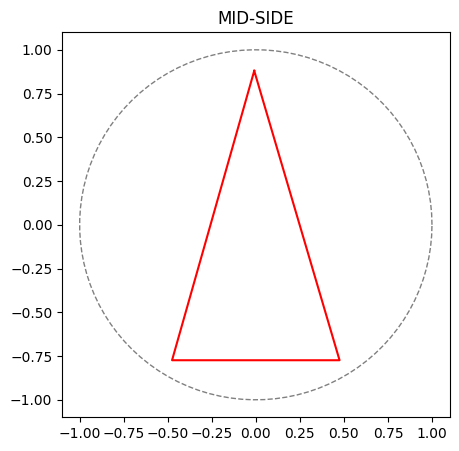

In [18]:
h_rate, w_rate = mid_side(stereo)
plot_triangle(h_rate, w_rate)

### LUFS en streaming mode (en algun moment pot servir)
https://essentia.upf.edu/reference/streaming_LoudnessEBUR128Filter.html


--------------------------------------------------------------------------------------------------------------
# CSV de les dades

El fitxer csv conté la informació de cada cançó en una fila. Cada fila té el número de la cançó, que en aquest cas no està ordenat, seguit per nom del fitxer, el gènere musica, els RMS, LUFS, LRA i el nombre de true peaks que superen el llindar. A partir d'això podrem obtenir les mitjanes i desviacions (variància) que serviran per a obtenir els presets de gènere.

In [19]:
import re

dict_data = []
path = '../master-dynamics/audio/'
for root_dir, cur_dir, files in os.walk(path):
    for n_song in range(len(files)):
        
        file_name = path + str(files[n_song])
        
        #find the numbers of the string,
        temp = re.findall(r'\d+', str(files[n_song]))
        #the first element in the list contain the song number
        res = list(map(int, temp))
        
        genre = genres[res[0]]
        
        audio = MonoLoader(filename=file_name)()
        stereo = AudioLoader(filename=file_name)()[0] #dos arrays esquerra i dreta
        RMS_v = rms_(audio)
        LUFS_v = LUFS_LRA_(stereo)[2]
        LRA_v = LUFS_LRA_(stereo)[3]
        PEAKS_v = len(true_peak_(audio)[0]) 
        CREST_v = crest_(audio)
        DR_v = DR_(audio)
        LR_coeff = mid_side(stereo)[0]
        MS_coeff = mid_side(stereo)[1]
        
        
        row = {'No':res[0],'Name':file_name, 'Genre':genre, 'RMS':RMS_v,'LUFS':LUFS_v, 'LRA':LRA_v, 
               'N peaks':PEAKS_v, 'DR':DR_v, 'Crest':CREST_v, 'LR coeff':LR_coeff, 'MS coeff':MS_coeff}
        
        dict_data.append(row)
        

        


In [20]:
import csv

csv_columns = ['No','Name','Genre','RMS', 'LUFS','LRA','N peaks','DR','Crest','LR coeff','MS coeff']

csv_file = "Data_info.csv"

try:
    with open(csv_file, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
        writer.writeheader()
        for data in dict_data:
            writer.writerow(data)
except IOError:
    print("I/O error")

--------------------------------------------------------------------------------------------------------------
# PRESETS

Ara a partir de tenir classificades les dades en funció del gènere musical serà fàcil obtenir els resultats. Per a fer això es farà ús de la llibreria pandas que farà de gestor de dades. REALMENT POTSER NO ÉS EL MÉS ÒPTIM PERÒ VOLEM SIMULAR QUE ES TREBALLA AMB UN GRAN NOMBRE DE  DADES AIXÍ ES POT INCLOURE AL PROJECTE DATA SCIENCE.

In [21]:
#os.system("pip install pandas")

import pandas as pd

csv_file = pd.read_csv('Data_info.csv')

csv_file.head()

,No,Name,Genre,RMS,LUFS,LRA,N peaks,DR,Crest,LR coeff,MS coeff
0,540,../master-dynamics/audio/540.mp3,reggaeton,0.302042,-7.345446,2.343201,379,196.00533,4.837374,-0.005548,0.309141
1,44,../master-dynamics/audio/44.mp3,classical,0.028993,-26.398939,9.634468,0,196.00533,9.915194,-0.002734,0.431837
2,613,../master-dynamics/audio/613.mp3,soul,0.257117,-9.035285,4.512865,0,196.00533,5.015667,0.003126,0.208030
3,247,../master-dynamics/audio/247.mp3,hip-hop,0.226135,-9.678103,2.521687,1817,196.00533,7.296312,0.000680,0.224277
4,110,../master-dynamics/audio/110.mp3,jazz,0.321843,-7.630418,1.183287,87,196.00533,3.997015,-0.001336,0.214285


Extract features

In [22]:
presets = []
for genre in all_genres:
    g = csv_file.loc[csv_file['Genre'] == genre]
    
    #RMS (mean, variance, median)
    RMS = [np.mean(g['RMS']),np.var(g['RMS']),np.median(g['RMS'])]
    
    #LUFS (mean, variance, median)
    LUFS = [np.mean(g['LUFS']),np.var(g['LUFS']),np.median(g['LUFS'])]
    
    #LRA (mean, variance, median)
    LRA = [np.mean(g['LRA']),np.var(g['LRA']),np.median(g['LRA'])]
    
    #Number of Peaks (mean, variance, median)
    PEAKS = [np.mean(g['N peaks']),np.var(g['N peaks']),np.median(g['N peaks'])]
    
    #Dynamic range (mean, variance, median)
    DR = [np.mean(g['DR']),np.var(g['DR']),np.median(g['DR'])]
    
    #Crest (mean, variance, median)
    CREST = [np.mean(g['Crest']),np.var(g['Crest']),np.median(g['Crest'])]
    
    #Mid-rise ratios (mean, variance, median)
    MS = [np.mean(g['MS coeff']),np.var(g['MS coeff']),np.median(g['MS coeff'])]
    LR = [np.mean(g['LR coeff']),np.var(g['LR coeff']),np.median(g['LR coeff'])]

    row = row = {'Genre':genre, 'RMS':RMS,'LUFS':LUFS, 'LRA':LRA, 'N peaks':PEAKS,
                'DR':DR, 'Crest':CREST, 'LR coeff':LR,'MS coeff':MS}
    
    presets.append(row)

In [23]:
presets

[{'Genre': 'k-pop',
  'RMS': [0.3140715772384091, 0.0037950893007812478, 0.3289004117250442],
  'LUFS': [-7.132142041858874, 3.0641720342050935, -6.6547040939331055],
  'LRA': [2.0364067805440804, 0.8693656695204088, 1.786304950714111],
  'N peaks': [1034.1842105263158, 3721658.1502770083, 240.5],
  'DR': [196.00533, 0.0, 196.00533],
  'Crest': [4.491349772403114, 0.764286135527683, 4.224877595901489],
  'LR coeff': [-0.001392213529662092,
   0.00010996472781130713,
   -7.119774818420001e-05],
  'MS coeff': [0.29318972434834345, 0.005249741555533021, 0.3112003766551469]},
 {'Genre': 'classical',
  'RMS': [0.0818446675315499, 0.0038500788367599624, 0.0596704315394163],
  'LUFS': [-19.10682266553243, 29.94034713407107, -20.163047790527344],
  'LRA': [8.42432902654012, 15.600284749171179, 8.88355541229248],
  'N peaks': [0.6666666666666666, 6.822222222222225, 0.0],
  'DR': [196.00533, 0.0, 196.00533],
  'Crest': [10.860354455312093, 16.082596196600115, 10.710838794708252],
  'LR coeff': [

In [24]:
## mediana, senyal LR-MS, dynamic range del mínim al max. s'ha de passar el senyal en absolut abans del peak
##mirar l'smooth d'essentia (però això més endavant)
#comparar crest amb peak/rms

In [25]:
csv_columns = ['Genre','RMS', 'LUFS','LRA','N peaks','DR','Crest','LR coeff','MS coeff']

csv_file = "Presets.csv"

try:
    with open(csv_file, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
        writer.writeheader()
        for data in presets:
            writer.writerow(data)
except IOError:
    print("I/O error")